# This Notebook details the **image only model**.

Although our project is mainly about the Multimodal model we wanted to have Unimodal baselines to compare the model with. 

Some of the implementation details of the image submodel are different from the multimodal model, since the textual modalities are irrelevant here. Therefore, the architecture has been simplified from the Multimodal model and attempts to follow the architecture of the image submodel of Aydin et al. (2019), which we are comparing our imlementation with. Some of the details of the model by Aydin et al.(2019) can be found here https://github.com/faikaydin/medical-multimodal-with-transfer-learning.

This file specifically https://github.com/faikaydin/medical-multimodal-with-transfer-learning/blob/master/multimodaling.ipynb shows the basic details of the image submodel in their implementation. 

Their model is implemented in Tensorflow/Keras, whereas ours is in Pytorch, which means that the code will look somewhat different.

# Imports:

In [5]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from pathlib import Path
import time
import os
import copy
from skimage import io
from PIL import Image
from sklearn.model_selection import train_test_split

# Skip Unless running in Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/LAP/
%pwd

/content/drive/MyDrive/LAP


'/content/drive/MyDrive/LAP'

## Resolve current directory

In [7]:
try:
    FILE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    print('__file__ does not exist for notebook, use current directory instead')
    FILE_DIR = Path().resolve()
    
print(f'current directory is: {FILE_DIR}')

__file__ does not exist for notebook, use current directory instead
current directory is: /content/drive/MyDrive/LAP


# Loading CheXNet:
The saved ChexNet model was created in the **Preparations.py** notebook already, where further details can be found. Here we simply load it and we have to map it to a device ('cuda'/'cpu')

In [9]:
SAVED_MODELS_DIR = 'models'
MODEL_PATH = os.path.join(SAVED_MODELS_DIR, 'saved_chexnet.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.isfile(MODEL_PATH):
    print("=> loading model...")
    chexnet = torch.load(MODEL_PATH, map_location=device)
    print('Model loaded.')
else:
    print("=> No model found.")

=> loading model...
Model loaded.


# Architecture:
This part displays the architecture of the ChexNet model, excluding the final classifier, which we will redefine later on in the notebook. ChexNet is basically just a DenseNet121 model, which has been further trained on large amount of  Chest X-Ray images, so the architecture is no different from a DenseNet.

In [10]:
chexnet_modules = list(chexnet.children())
chexnet_modules_inside = list(chexnet_modules[0].children())
chexnet_modules_inside[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 _DenseBlock(
   (denselayer1): _DenseLayer(
     (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu1): ReLU(inplace=True)
     (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu2): ReLU(inplace=True)
     (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   )
   (denselayer2): _DenseLayer(
     (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu1): ReLU(inplace=True)
     (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (norm2): BatchNorm2d(128, 

# Dataset
Defines the dataset class, which is basically a torch Dataset with some customization. As mentioned above, the image dataset is quite simplified from the JSONDataset used in the multimodal model, simply because a lot of the features there are unneccesary in this case.

In [11]:
class ImageDataSet(Dataset):

    def __init__(self, csv_file, root_dir, transform):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.data.iloc[index, 1]))

        pil_image = Image.fromarray(image)
        image = self.transform(pil_image)

        return image, y_label

# Image Transformations:

The DenseNet architecture expects images in a specific format so we need to resize and center the images accordingly as well as normalize the images according to the specifications.

Below we instantiate the dataset.

In [12]:
#image transformations: has to be compatible with the format DenseNet expects
image_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


CSV_DIR = 'image_labels_csv'
FILENAME = 'image_labels_impression_frontal' # image_labels_findings_frontal
IMG_DIR = 'NLMCXR_png_frontal'

dataset = ImageDataSet(csv_file=os.path.join(CSV_DIR, FILENAME)+'.csv', root_dir=IMG_DIR, transform=image_transforms)

# Train, Validation, and Test Set Partitioning
We partition all the original csv files into a 60/20/20 Train/Validation/Test partitions.

We use the standard sklearn train_test_split function with the specified random_state = 1 to create the partitions with reproducibility.

In [13]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=1)
train_set, valid_set = train_test_split(train_set, test_size=0.25, random_state=1)


BATCH_SIZE = 32
# if len(dataset) is not divisible by batch_size, need to drop last mini-batch
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


dataloaders = {
    'train': train_loader,
    'val': valid_loader,
    'test': test_loader
}


print(f'Total examples in dataset: {len(dataset)}')
print(f'Training examples: {len(train_set)}')
print(f'Validation examples: {len(valid_set)}')
print(f'Test examples: {len(test_set)}')

Total examples in dataset: 3246
Training examples: 1947
Validation examples: 649
Test examples: 650


# The train/eval function:


This is fairly basic and generic train and evaluation function that keeps track of the loss and accuracy history for later visualization.



In [14]:
#train/eval function.
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    if phase == 'train':
                        outputs = model(inputs)
                        
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

# What Parameters do we want to include in the model:

In [15]:
# choose whether to freeze the weights of the model or not, based on boolean value of feature_extracting
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# If weights are frozen, this function allows unfreezing chosen layers.
def unfreeze_layer(model, layers=[]):
  if feature_extracting:
    for layer in layers:
      for name,param in model.named_parameters():
        if param.requires_grad == False:
          if layer in name:
            param.requires_grad = True

In [16]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
FEATURE_EXTRACT = True

set_parameter_requires_grad(chexnet, FEATURE_EXTRACT) # freeze all parameters

# Example of unfreezing the last 2 layers
#unfreeze_layer(chexnet, ['norm5','denseblock4'])

# Redefining the classifier:

As the original ChexNet was trained on multiclass (14 classes) classification of thoratic diseases, we need to change the classifier in our model to output 2 classes: 'normal' and 'abnormal'.

In addition to this, the classifier in ChexNet consisted of a sinlge linear layer and a Sigmoid activation. In our implementation we followed the implementation of Aydin et al. (2019). What constitutes as a classifier here is basically what Aydin et al. (2019) called the 'Image Decoder'. First we feed in the output from the last layer before classifier (the logits). Then we normalize the output through a Batch Normalization and feed the output through a dense linear layer. The activations are the propagated through a ReLU() function and dropout is applied (for the next part). Finally we feed the output through another Batch Normalization and a dense linear layer that maps the output to the number of classes. The outputs will still go through a softmax but since we use CrossEntropyLoss() the softmax is called within the loss function itself.

In [17]:
NUM_CLASSES = 2
NUM_FTRS = 1024

#.densenet121
chexnet.classifier = nn.Sequential(
            nn.BatchNorm1d(NUM_FTRS),
            nn.Linear(NUM_FTRS, int(NUM_FTRS/2)),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(int(NUM_FTRS/2)),
            nn.Linear(int(NUM_FTRS/2), NUM_CLASSES)
            #nn.Softmax()
            
        )

model_ft = chexnet.to(device)

# Learnable Parameters:
We need to specifically extract the learnable parameters from the model here and feed them into the optimizer below. Although we already set the 'requires_grad=False' for all the parameters we chose to freeze, the optimizer does not care about this and we need to specify only the parameters that have 'requires_grad=True' as parameters to optimize.

In [18]:
# choose which parameters we want to update and with not --> params_to_update is sent as an attribute into the optimizer so it knows which gradients to update/not
params_to_update = model_ft.parameters()
print("Params to learn:")
if FEATURE_EXTRACT:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.5.weight
	 classifier.5.bias


# Running the model and visualising the accuracy/loss:

We experimented with different optimizers but settled on the Adam optimizer, since that's also what Aydin et al. (2019) used in their implementation.

We also chose the Cross Entropy as our loss function following Aydin's implementation.



In [19]:
NUM_EPOCHS = 5

# Observe that all parameters are being optimized
optimizer = optim.Adam(params_to_update, lr=0.0001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc, train_acc, val_loss, train_loss = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 1/5
----------
train Loss: 0.6035 Acc: 0.6723
val Loss: 0.5639 Acc: 0.5008

Epoch 2/5
----------
train Loss: 0.5556 Acc: 0.7021
val Loss: 0.6174 Acc: 0.5162

Epoch 3/5
----------
train Loss: 0.5328 Acc: 0.7196
val Loss: 0.5473 Acc: 0.5177

Epoch 4/5
----------
train Loss: 0.4996 Acc: 0.7422
val Loss: 0.3721 Acc: 0.5193

Epoch 5/5
----------
train Loss: 0.5029 Acc: 0.7458
val Loss: 0.5179 Acc: 0.5300

Training complete in 0m 35s
Best val Acc: 0.530046


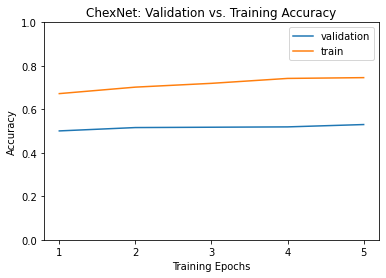

In [20]:
val_acc_hist = [h.cpu().numpy() for h in val_acc]
train_acc_hist = [h.cpu().numpy() for h in train_acc]


plt.title("ChexNet: Validation vs. Training Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,NUM_EPOCHS+1),val_acc_hist,label="validation")
plt.plot(range(1,NUM_EPOCHS+1),train_acc_hist,label='train')
plt.ylim((0,1.))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()


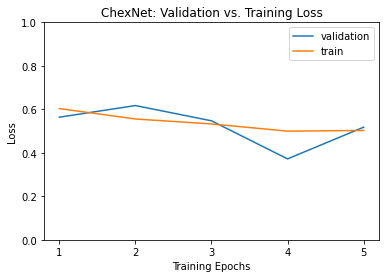

In [21]:
val_loss_hist = [h for h in val_loss]
train_loss_hist = [h for h in train_loss]


plt.title("ChexNet: Validation vs. Training Loss")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,NUM_EPOCHS+1),val_loss_hist,label="validation")
plt.plot(range(1,NUM_EPOCHS+1),train_loss_hist,label='train')
plt.ylim((0,1.))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()

As we can see from the plots above, the image submodel does not learn to generalize well and seems to only be overfitting to the training data with more epochs.

This is a problem we need to consult the authors of the paper about, since in their implementation they got a validation accuracy of 0.77 from the image submodel and although we are following very closely their implementation something is not working here as supposed to.

However, this does not seem to be a major problem for our Multimodal model in the sense that because our text model performed so well on its own the accuracy of the multimodal model is still very high.

On the other hand, this probably also means that there is not much cross-modal interaction going on, since the image embeddings don't seem to add much useful information.

# Saves the model to the appropriate folder:

In [23]:
MODEL_PATH = 'models/image_only/'
if FEATURE_EXTRACT:
  state = '_frozen_'
else:
  state = '_unfrozen_'

torch.save(model_ft.state_dict(), MODEL_PATH+FILENAME+state+str(NUM_EPOCHS)+'.pt')
print('Model saved.')

Model saved.


# Integrated Gradients:

The basic idea behind integrated gradients is that we can make use of the learned weights, which allow us to take the partial derivative w/ respect to the inputs (the pixels). By doing so allows us to pull some explanations from the image model with respect to what the model is paying the most attention to when trying to classify an image.

As ChexNet was trained on classifying thoratic diseases from frontal X-Ray images and as our model simply finetunes that model into a binary classification problem of 'normal' (no disease) and 'abnormal' (some kind of disease), the task itself forces the model to look for some kind of anomalies in the image that might indicate abnormality.


The code for extracting the Integrated Gradients is located on a separate script in the folder 'integrated_gradients' and is based on this open source implementation of Integrated Gradients: https://github.com/TianhongDai/integrated-gradient-pytorch (MIT License).

Two Chest X-Ray images are already added into the correct subfolder for testing purposes here. We chose a pair of normal/abnormal images to compare them together.

In [36]:
# drive=True only when running on Google Colab, default=False
!python ./integrated_gradients/main.py --cuda --model-type='chexnet' --img='CXR2246_IM-0843-1001_abnormal.png' --drive=True
!python ./integrated_gradients/main.py --cuda --model-type='chexnet' --img='CXR15_IM-0324-1001_normal.png' --drive=True

the trial number is: 0
the trial number is: 1
the trial number is: 2
the trial number is: 3
the trial number is: 4
the trial number is: 5
the trial number is: 6
the trial number is: 7
the trial number is: 8
the trial number is: 9
the trial number is: 0
the trial number is: 1
the trial number is: 2
the trial number is: 3
the trial number is: 4
the trial number is: 5
the trial number is: 6
the trial number is: 7
the trial number is: 8
the trial number is: 9


# Extract text belonging to chosen images
After running the script we still want to extract the text (impression) belonging to those 2 images for demonstration. 

The simplest way to do this is just to create a Pandas Dataframe from the appropriate dataset file and extract the 'text' field from those two specific image IDs.

In [37]:
df = pd.read_csv(os.path.join(CSV_DIR, FILENAME)+'.csv')
df = df.rename(columns={"Filename": "img", "Label": "label", "LabelText": "text"})
df.head()

,img,label,text
0,CXR2_IM-0652-1001.png,0,no acute pulmonary findings.
1,CXR6_IM-2192-1001.png,0,no acute cardiopulmonary findings.
2,CXR8_IM-2333-1001.png,0,no acute cardiopulmonary disease.
3,CXR10_IM-0002-1001.png,0,no acute cardiopulmonary process.
4,CXR11_IM-0067-1001.png,0,no acute cardiopulmonary findings.


In [38]:
abnormal = df[df['img'].str.match('CXR2246_IM-0843-1001.png')]
normal = df[df['img'].str.match('CXR15_IM-0324-1001.png')]

normal_text = normal['text'].values[0]
abnormal_text = abnormal['text'].values[0]

print(normal_text)
print(abnormal_text)

no acute cardiopulmonary findings.
right lung base airspace disease and left base atelectasis.


# Visualization of Integrated Gradients:

On the left here we have the original Chest X-Ray image, on the centre we have the visualized integrated gradients from that image and on the right we have all gradients multiplied to the image.

One thing worth noticing here is that although the image model did not seem to perform all that well we can still see a clear difference in the gradients between a normal and an abnormal image. This could also be somewhat coincidental as these examples were chosen somewhat randomly, but there seems to be a visible pattern here regardless.

In the normal image the integrated gradients seem to be all over the image, likely because the model is not able to find any clear patterns in the data, whereas in the abnormal case the integrated gradients are much more concentrated on specific areas of the image, possibly indicating an abnormality. If we look at the text associated to this image: "right lung base airspace disease and left base atelectasis." we can see that there are two concentrations of gradients roughly around those areas. Therefore, it seems that despite a poor ability to generalize the model is able to find some patterns of abnormality at least in some of the images.

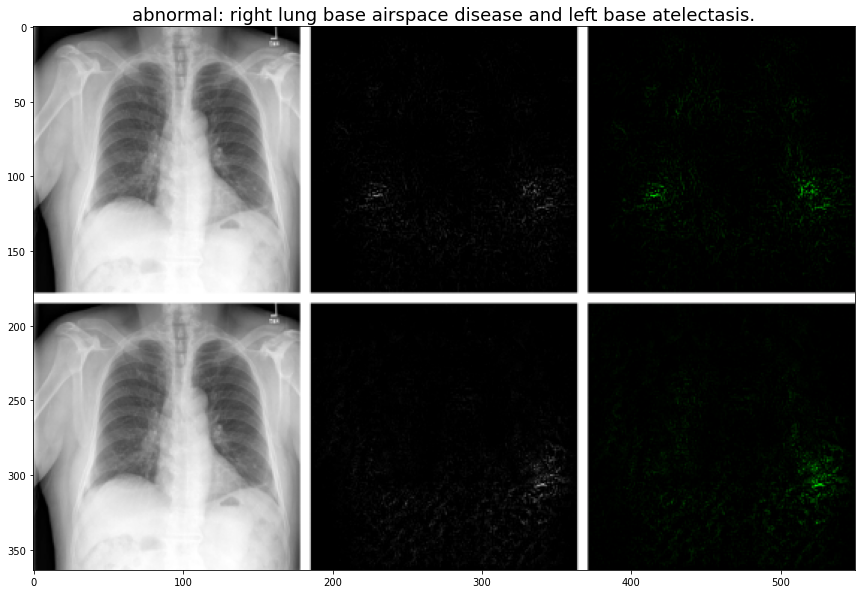

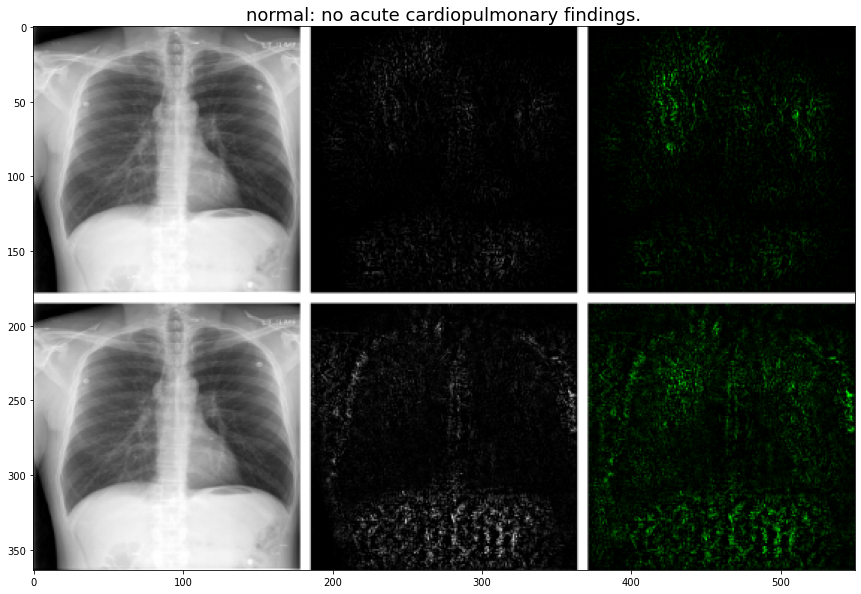

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

PATH = os.path.join(FILE_DIR, 'integrated_gradients') + '/results/chexnet/'

for filename in os.listdir(PATH):
    if 'ab' in filename:
      title = 'abnormal: '+abnormal_text
    else:
      title = 'normal: '+normal_text
    image = mpimg.imread(PATH+filename)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    plt.imshow(image)
    ax.plot()
    ax.set_title(title, fontsize=18)

# Skip Unless running in Google Colab

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')